# Implementar o Conditional GAN

- Usar Conditional GAN: [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) com o dataset MNIST.

In [1]:
import struct
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch import nn
import matplotlib.pyplot as plt

In [2]:
file_images = '/home/ninja/MNIST/train-images.idx3-ubyte'
file_labels = '/home/ninja/MNIST/train-labels.idx1-ubyte'

In [4]:
with open(file_images,'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data1 = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    data1 = data1.reshape((size, nrows, ncols))

data1.shape

(60000, 28, 28)

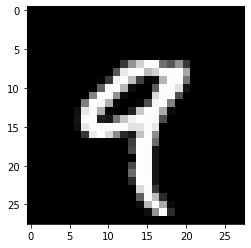

In [4]:
plt.imshow(data1[4,:,:], cmap='gray')
plt.show()

In [5]:
data = data1.reshape(data1.shape[0],data1.shape[1]*data1.shape[2])
data.shape

(60000, 784)

In [6]:
with open(file_labels,'rb') as f:
    labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))

labels = labels[8:]
labels.shape

(60000,)

## ConditionalGAN - MNIST

---
* Funções de auxílio

In [7]:
def plot_losses(losses_his,title='losses'):
    plt.figure(figsize=(20,8))
    plt.subplot(221)
    plt.plot(losses_his[0])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Gerador')
    plt.subplot(222)
    plt.plot(losses_his[1])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador')
    plt.subplot(223)
    plt.plot(losses_his[2])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Real')
    plt.subplot(224)
    plt.plot(losses_his[3])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Falso')
#     plt.savefig('images/'+title+'.png',quality=100)
    plt.show()

def plot_digit(x):
    x = x.data.numpy().reshape(data1.shape[1],data1.shape[2])
    plt.imshow(x,cmap='gray_r')
    plt.show()
    
def plot_n_random_digits(x,labels=None,n_images=9,title='gan_random_digits'):
    """Ate 20 imagens"""
    indices = np.random.choice(x.shape[0],size=n_images)
    x = x[indices].data.numpy()
    if isinstance(labels, torch.IntTensor):
        sample_labels = labels[indices].data.numpy()
    else: sample_labels = ['None']*len(indices)
    x = x.reshape(n_images,data1.shape[1],data1.shape[2])
    plt.clf()
    plt.style.use('seaborn-muted')
    fig, axes = plt.subplots(2,10, figsize=(15,3), sharex=True, sharey=True,
                             subplot_kw=dict(adjustable='box', aspect='equal'))
    for i in range(n_images):
        subplot_row = i//10
        subplot_col = i%10  
        ax = axes[subplot_row, subplot_col]
        plottable_image = x[i,:]
        ax.imshow(plottable_image, cmap='gray_r')
        ax.set_title('Digit Label: {}'.format(sample_labels[i]))
        ax.set_xbound([0,28])
    plt.tight_layout()
#     plt.savefig('images/'+title+'.png',quality=100)
    plt.show()

def print_label(label):
    chosen_label = label
    batch = 1000
    y_sample = np.zeros(shape=[batch, y_dim])
    y_sample[:,chosen_label] = 1
    y_sample_tc = torch.Tensor(y_sample).type(torch.IntTensor)
    plot_n_random_digits(G(Variable(torch.randn(batch, Z_dim)).cuda(),
                         y_sample_tc.type(torch.FloatTensor).cuda()).cpu(),
                         labels=torch.max(y_sample_tc,dim=1)[1].type(torch.IntTensor),
                         n_images=20,title='conditional_gan_generated_{}_{}_'.format(chosen_label,epochs))
    
def nets_test(n_sample,G,D):
    z = Variable(torch.randn(n_sample, Z_dim)).cuda()
    x = torch.Tensor(X_tc[:n_sample]).cuda()
    l = torch.Tensor(y_tc[:n_sample]).cuda()
    g = G(z,l)
    D_real = D(x,l)
    D_fake = D(g,l)
    print('Average D_real  {:.6f}| Std D_real  {:.6f}'.format(D_real.mean(),D_real.std()))
    print('Average D_fake  {:.6f}| Std D_fake  {:.6f}'.format(D_fake.mean(),D_fake.std()))

---

In [8]:
data = MinMaxScaler().fit_transform(data)

In [9]:
# X_data = MinMaxScaler().fit_transform(data)
X_tc = torch.Tensor(data).type(torch.FloatTensor)
y_tc = torch.Tensor(np.eye(10)[labels]).type(torch.FloatTensor)
print(X_tc.shape, X_tc.type(),y_tc.shape, y_tc.type())

torch.Size([60000, 784]) torch.FloatTensor torch.Size([60000, 10]) torch.FloatTensor


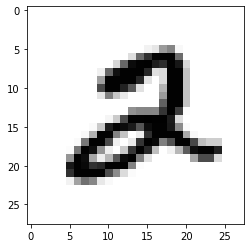

In [10]:
plot_digit(X_tc[5])

<Figure size 432x288 with 0 Axes>

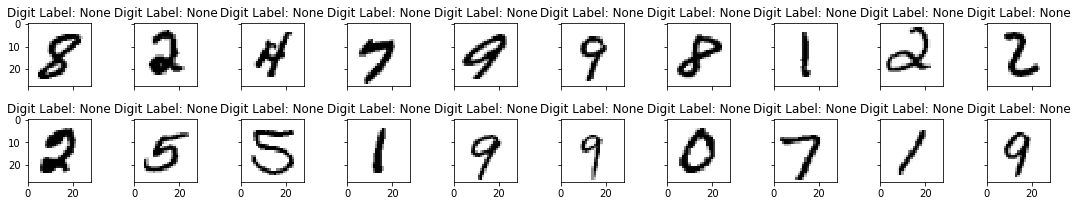

In [11]:
plot_n_random_digits(X_tc,n_images=20)

In [12]:
batch_size = 32
X_dim = X_tc.shape[1]
y_dim = y_tc.shape[1]
torch_dataset = Data.TensorDataset(X_tc,y_tc)
loader = Data.DataLoader(
        dataset = torch_dataset,
        batch_size = batch_size,
        shuffle=True,
        pin_memory=True)

In [ ]:
Z_dim,h_dim,X_dim,y_dim = [100,128,X_tc.shape[1],y_tc.shape[1]]

# Arquitetura do Gerador
class GNet(torch.nn.Module):
    def __init__(self):
        super(GNet,self).__init__()
        self.hidden = torch.nn.Linear(Z_dim+y_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, X_dim)
    
    def forward(self,z,l):
        h = F.relu(self.hidden(torch.cat((z,l),dim=1)))
        h = nn.Dropout(p=0.5)(h)
        X = torch.sigmoid(self.out(h))
        return X

# Arquitetura do Discriminador
class DNet(torch.nn.Module):
    def __init__(self):
        super(DNet,self).__init__()
        self.hidden = torch.nn.Linear(X_dim+y_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, 1)
    
    def forward(self,X,l):
        h = F.relu(self.hidden(torch.cat((X,l),dim=1)))
        h = nn.Dropout(p=0.5)(h)
        y = torch.sigmoid(self.out(h))
        return y

# Instanciamos as redes
G = GNet().cuda()
D = DNet().cuda()

# Definimos os otimizadores
lrg,lrd = [1e-3,1e-3]
G_optim = optim.Adam(G.parameters(), lr=lrg)
D_optim = optim.Adam(D.parameters(), lr=lrd)

def reset_grad():
    G_optim.zero_grad()
    D_optim.zero_grad()

D_loss_real_func = nn.BCELoss()  
D_loss_fake_func = nn.BCELoss()
G_loss_func = nn.BCELoss()

In [ ]:
#load saved networks
G.load_state_dict(torch.load('models/g_cond_gan_mnist_25k.pt'))
D.load_state_dict(torch.load('models/d_cond_gan_mnist_25k.pt'))

In [ ]:
%%time
epochs = 4000

G_his, D_his, D_real_his, D_fake_his = [[],[],[],[]]
losses_his = [G_his,D_his,D_real_his,D_fake_his] 

batch = X_tc.shape[0]

ones  = Variable(torch.ones(batch, 1)).cuda()
zeros = Variable(torch.zeros(batch, 1)).cuda()

for epoch in range(epochs):
    # Amostragem de dados
    z = Variable(torch.randn(batch, Z_dim)).cuda()
    X = X_tc[:batch].cuda()
    l = y_tc[:batch].cuda()
    # Dicriminador
    G_sample = G(z,l)
    D_real = D(X,l)
    D_fake = D(G_sample,l)
    D_loss_real = D_loss_real_func(D_real, ones)
    D_loss_fake = D_loss_fake_func(D_fake, zeros)
    D_loss = D_loss_real + D_loss_fake
    D_loss.backward()
    D_optim.step()
    reset_grad()
    # Generador
    z = Variable(torch.randn(batch, Z_dim)).cuda()
    G_sample = G(z,l)
    D_fake = D(G_sample,l)
    G_loss = G_loss_func(D_fake, ones)
    G_loss.backward()
    G_optim.step()
    reset_grad()
    # Recolher dados das funções de perda
    G_his.append(G_loss.mean().data)
    D_his.append(D_loss.mean().data)
    D_fake_his.append(D_loss_fake.mean().data)
    D_real_his.append(D_loss_real.mean().data)
    # Mostrar dados ao longo das epochs
    if epoch % int(epochs/3) == 0 and epoch > 0:
        print('Epoch-{}| Average D_loss: {:.5f}| Average G_loss: {:.5f}| Average D_real: {:.5f} | Average D_fake: {:.5f}'.format(
            epoch, D_loss.data, G_loss.data, D_loss_real.data, D_loss_fake.data))
        nets_test(30000,G,D)
        print_label(label=5)
        plot_losses(losses_his,title=f'gan_losses_{epoch}')

Average D_real  0.767862| Std D_real  0.292891
Average D_fake  0.238673| Std D_fake  0.193654


<Figure size 432x288 with 0 Axes>

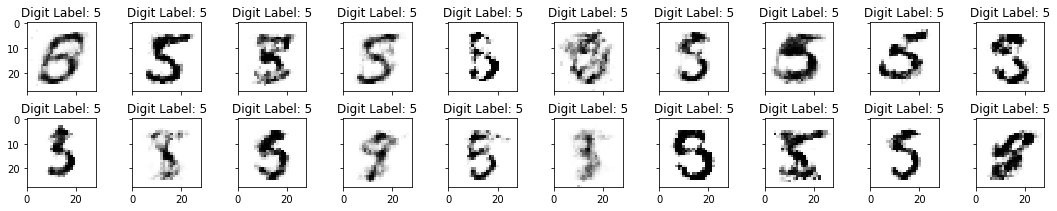

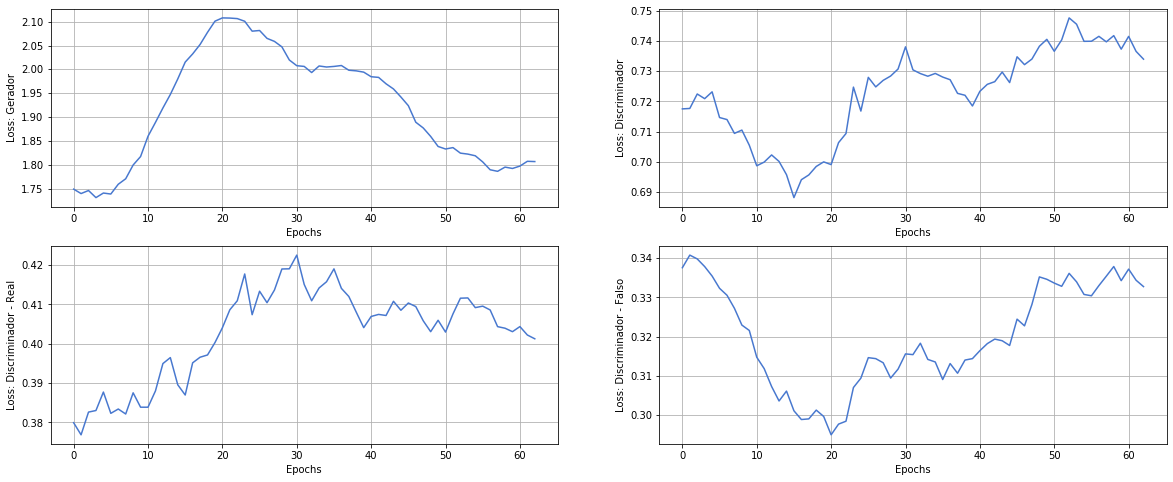

In [16]:
# 15k epochs
nets_test(1000,G,D)
print_label(5)
plot_losses(losses_his,title=f'gan_losses_{epochs}')

<Figure size 432x288 with 0 Axes>

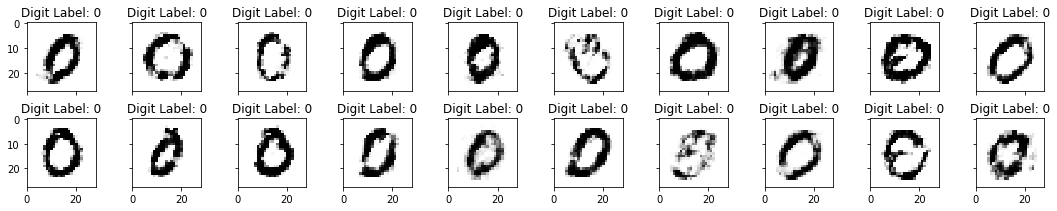

<Figure size 432x288 with 0 Axes>

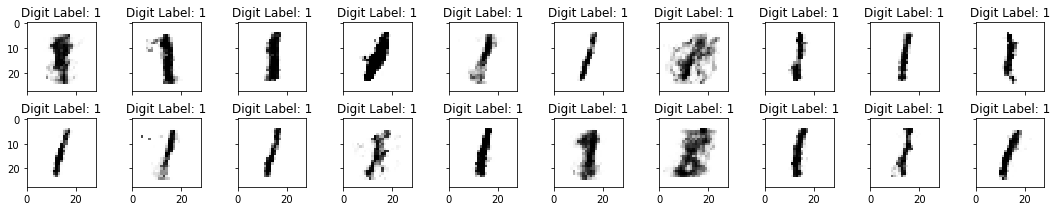

<Figure size 432x288 with 0 Axes>

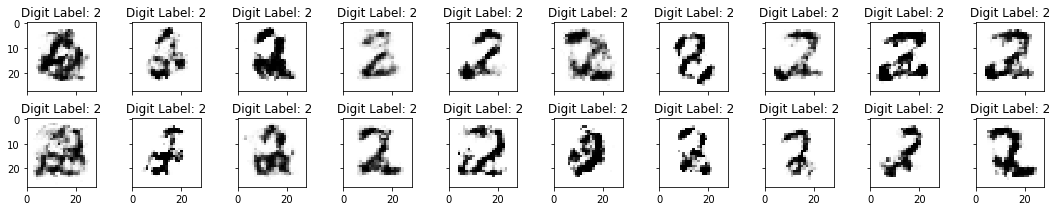

<Figure size 432x288 with 0 Axes>

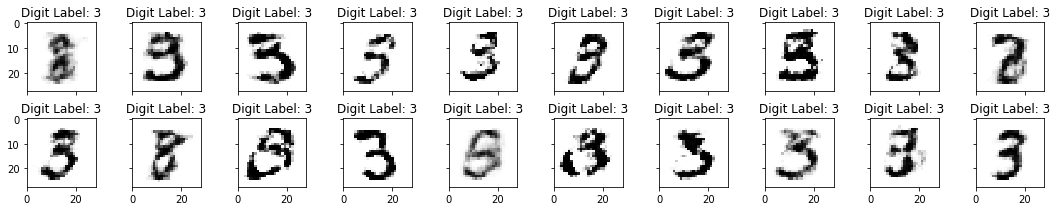

<Figure size 432x288 with 0 Axes>

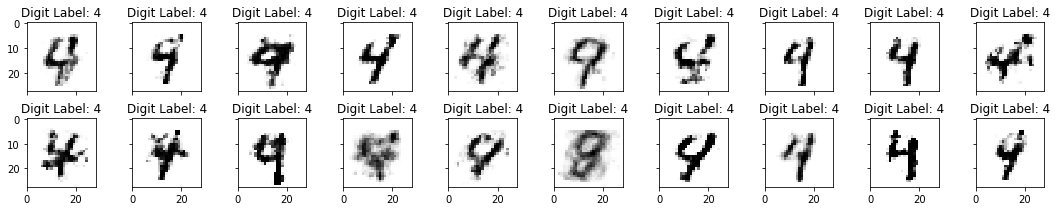

<Figure size 432x288 with 0 Axes>

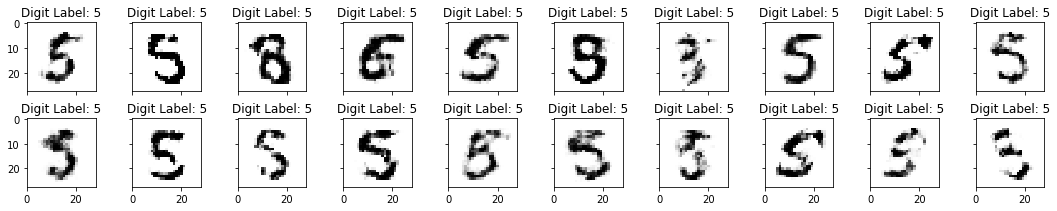

<Figure size 432x288 with 0 Axes>

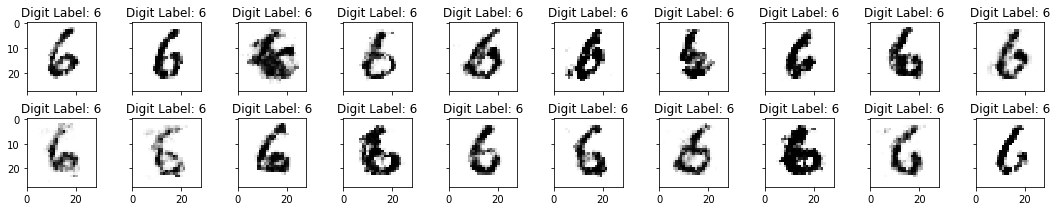

<Figure size 432x288 with 0 Axes>

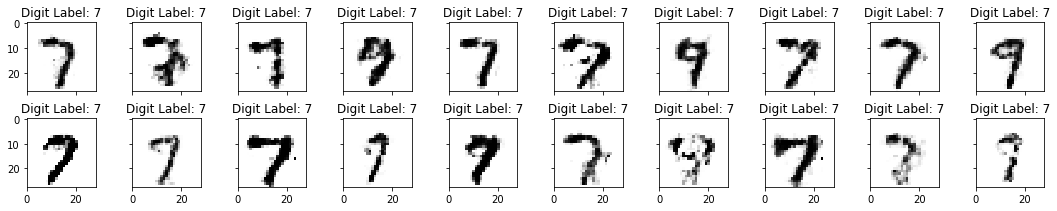

<Figure size 432x288 with 0 Axes>

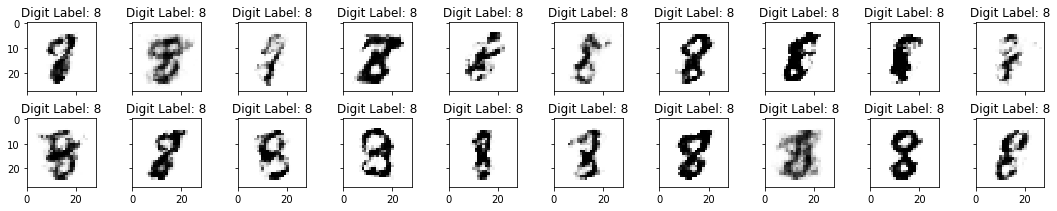

<Figure size 432x288 with 0 Axes>

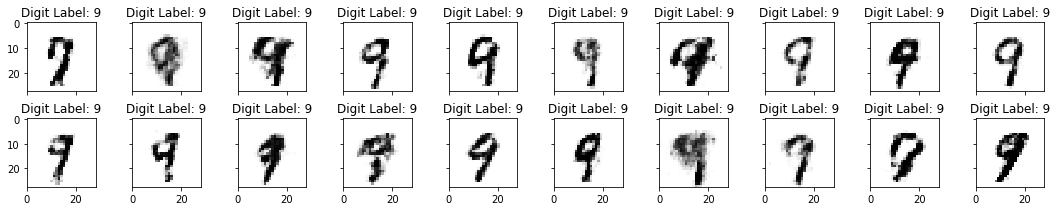

[None, None, None, None, None, None, None, None, None, None]

In [17]:
[print_label(i) for i in range(10)]

In [21]:
# #save networks
# torch.save(G.state_dict(), 'models/g_cond_gan_mnist_25k.pt')
# torch.save(D.state_dict(), 'models/d_cond_gan_mnist_25k.pt')

In [22]:
label_test = torch.Tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]).reshape(1,y_dim).cuda()

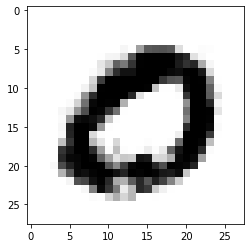

In [26]:
plot_digit(G(Variable(torch.randn(1, Z_dim)).cuda(),label_test).cpu())